# Cycle Gan with LS Loss
Cycle Gan is another revolutionary paper which performs image to image translations without unpaired Data. Basically what that means is that we can convert horses to zebra without having paired images of each. This opens up a huge array of possibilities such as Image to Painting and Painting to Image which is explored here.  
![alt text](https://miro.medium.com/max/2692/1*_KxtJIVtZjVaxxl-Yl1vJg.png)

So what exactly is happening? Well we have 2 Generators A and B and 2 Discriminators. G_A converts A to B and D_B checks its validity. We have 3 kinds of losses - 
+ Normal GAN loss ([LSGAN loss](https://machinelearningmastery.com/least-squares-generative-adversarial-network/))), for both discriminators and generators
+ Cycle Consistency Loss - L1 loss between image and its reconstruction ( G(F(x))-x)) for both the networks
+ Identity Loss - To ensure that while reconstructing the tint or contrast arent changed

In [93]:
from __future__ import print_function
import time
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import random

import numpy as np

import os , itertools
print(os.listdir("../input/cyclegan/vangogh2photo"))

import matplotlib.pyplot as plt

['vangogh2photo', 'trainB', 'trainA', 'testB', 'testA']


In [94]:
PATH = "../input/cyclegan/vangogh2photo/"
len(os.listdir(PATH+'testB'))

751

In [96]:
params = {
    'batch_size':1,
    'input_size':256,
    'resize_scale':286,
    'crop_size':256,
    'fliplr':True,
    #model params
    'num_epochs':5,
    'decay_epoch':100,
    'ngf':32,   #number of generator filters
    'ndf':64,   #number of discriminator filters
    'num_resnet':6, #number of resnet blocks
    'lrG':0.0001,    #learning rate for generator
    'lrD':0.0004,    #learning rate for discriminator
    'beta1':0.5 ,    #beta1 for Adam optimizer
    'beta2':0.999 ,  #beta2 for Adam optimizer
    'lambdaA':10 ,   #lambdaA for cycle loss
    'lambdaB':10  ,  #lambdaB for cycle loss
}


B contains real world images. A contains paintings. The size of the images are 256x256.

In [97]:
def to_np(x):
    return x.data.cpu().numpy()
def plot_train_result(real_image, gen_image, recon_image, epoch, save=False,  output = '.',show=True, fig_size=(15, 15)):
    fig, axes = plt.subplots(2, 3, figsize=fig_size)
    imgs = [to_np(real_image[0]), to_np(gen_image[0]), to_np(recon_image[0]),
            to_np(real_image[1]), to_np(gen_image[1]), to_np(recon_image[1])]
    for ax, img in zip(axes.flatten(), imgs):
        ax.axis('off')
        #ax.set_adjustable('box-forced')
        # Scale to 0-255
        img = img.squeeze()
        img = (((img - img.min()) * 255) / (img.max() - img.min())).transpose(1, 2, 0).astype(np.uint8)
        ax.imshow(img, cmap=None, aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)

    title = 'Epoch {0}'.format(epoch + 1)
    fig.text(0.5, 0.04, title, ha='center')

    # save figure
    if save:
        save_fn = output+'Result_epoch_{:d}'.format(epoch+1) + '.png'
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()
        
# This function helps us randomly sample an image or a batch of images    
class ImagePool():
    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        if self.pool_size == 0:
            return images
        return_images = []
        for image in images.data:
            image = torch.unsqueeze(image, 0)
            if self.num_imgs < self.pool_size:
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:
                    random_id = random.randint(0, self.pool_size-1)
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:
                    return_images.append(image)
        return_images = Variable(torch.cat(return_images, 0))
        return return_images

In [98]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
    
        self.img_dir = img_dir
        self.img_names = os.listdir(img_dir)
        self.transform = transform

    def __getitem__(self, index):
        img_name = self.img_names[index]
        img = Image.open(os.path.join(self.img_dir,img_name))
        if self.transform is not None:
            imgy = self.transform(img)
        
        return imgy

    def __len__(self):
        return len(self.img_names)

In [99]:
transform = transforms.Compose([
    transforms.Resize(size=params['input_size']),
    transforms.CenterCrop(size=params['input_size']),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
train_data_A = ImageDataset(PATH+'trainA/',transform)
train_data_B = ImageDataset(PATH+'trainB/',transform)
test_data_A = ImageDataset(PATH+'testA/',transform)
test_data_B = ImageDataset(PATH+'testB/',transform)

train_data_loader_A = DataLoader(dataset=train_data_A,batch_size=params['batch_size'],shuffle=True)
train_data_loader_B = DataLoader(dataset=train_data_B,batch_size=params['batch_size'],shuffle=True)
test_data_loader_A = DataLoader(dataset=test_data_A,batch_size=params['batch_size'],shuffle=True)
test_data_loader_B = DataLoader(dataset=test_data_B,batch_size=params['batch_size'],shuffle=True)
# print(train_data_A.__len__())

Normalized Images from Paintings Set

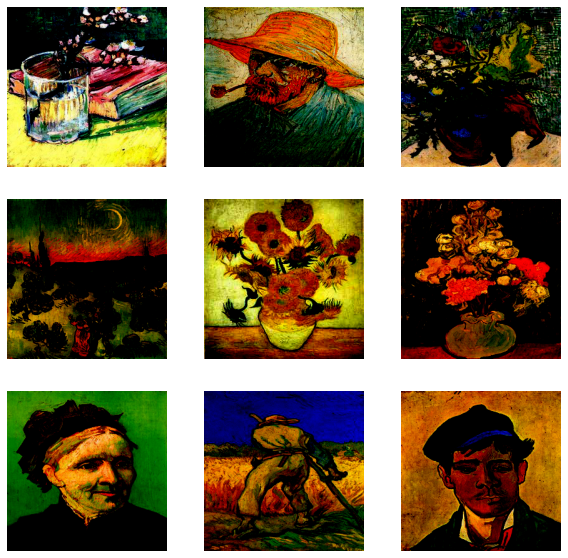

In [100]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    imgs = next(iter(train_data_loader_A))
    imgs = imgs.numpy().transpose(0,2,3,1)
    plt.axis('off')
    plt.imshow(imgs[0])

Normalized Images from Photos Set

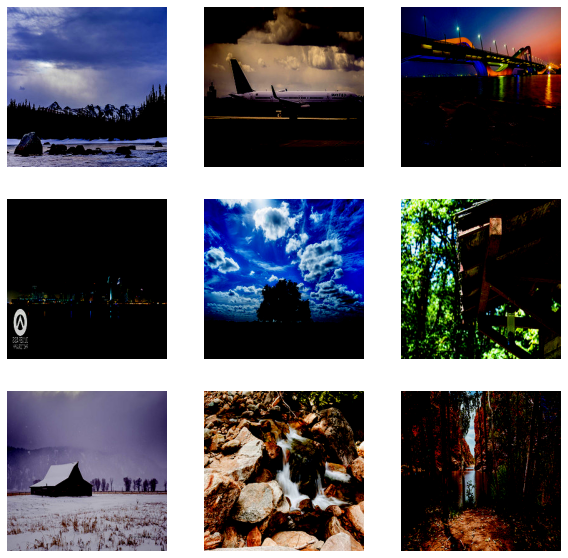

In [101]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    imgs = next(iter(train_data_loader_B))
    imgs = imgs.numpy().transpose(0,2,3,1)
    plt.axis('off')
    plt.imshow(imgs[0])

Instance norm has the effect of making the output invariant to mean and variance of each feature channel of the input. This is the same idea as contrast normalization  
This prevents instance-specific mean and covariance shift simplifying the learning process  
Generator network should discard contrast information in the contentimage  

In [102]:
class SpectralNorm(nn.Module):
    def __init__(self,module):
        super().__init__()
        self.module = nn.utils.spectral_norm(module)
    def forward(self,x):
        return self.module(x)

In [121]:
class Convolution(nn.Module):
    def __init__(self,input_size,output_size,kernel=3,stride=2,padding=1,activation='relu',instance_norm=True):
        super(Convolution,self).__init__()
        self.conv = nn.Conv2d(input_size,output_size,kernel,stride,padding,bias=False)
        self.instance_norm = instance_norm
        self.instance = nn.InstanceNorm2d(output_size)
        self.activation = activation
        self.relu = nn.ReLU(inplace=True)
        self.lrelu = nn.LeakyReLU(0.2,True)
        self.tanh = nn.Tanh()
        
    def forward(self,x):
        if self.instance_norm:
            output = self.instance(self.conv(x))
        else:
            output = self.conv(x)
        
        if self.activation == 'relu':
            return self.relu(output)
        elif self.activation == 'lrelu':
            return self.lrelu(output)
        elif self.activation == 'tanh':
            return self.tanh(output)
        elif self.activation == 'none':
            return output

class Deconvolution(nn.Module):
    def __init__(self,input_size,output_size,kernel=3,stride=2,padding=1,output_padding=1,activation='relu',instance_norm=True):
        super(Deconvolution,self).__init__()
        self.deconv = nn.ConvTranspose2d(input_size,output_size,kernel,stride,padding,output_padding=1,bias=False)
        self.instance_norm = instance_norm
        self.instance = nn.InstanceNorm2d(output_size)
        self.activation = activation
        self.relu = nn.ReLU(inplace=True)
        self.lrelu = nn.LeakyReLU(0.2,True)
        self.tanh = nn.Tanh()
        
    def forward(self,x):
        if self.instance_norm:
            output = self.instance(self.deconv(x))
        else:
            output = self.conv(x)
        
        if self.activation == 'relu':
            return self.relu(output)
        elif self.activation == 'lrelu':
            return self.lrelu(output)
        elif self.activation == 'tanh':
            return self.tanh(output)
        elif self.activation == 'none':
            return output

In [104]:
class ResnetBlock(nn.Module):
    def __init__(self,num_filter,kernel_size=3,stride=1,padding=0):
        super(ResnetBlock,self).__init__()
        conv1 = SpectralNorm(nn.Conv2d(num_filter,num_filter,kernel_size,stride,padding))
        conv2 = SpectralNorm(nn.Conv2d(num_filter,num_filter,kernel_size,stride,padding))
        innorm = nn.InstanceNorm2d(num_filter)
        relu = nn.ReLU(inplace=True)
        pad = nn.ReflectionPad2d(1)
        
        
        self.resnet_block = nn.Sequential(pad,conv1,innorm,relu,pad,conv2,innorm)
        
    def forward(self,x):
        return self.resnet_block(x)

In [120]:
class Generator(nn.Module):
    def __init__(self,input_dim,num_filter,output_dim,num_blocks):
        super(Generator,self).__init__()
            
#             Reflection padding
        self.pad = nn.ReflectionPad2d(3)
#         encoder. we encode it first to a latent space and then we apply our generator logics
        self.conv1 = Convolution(input_dim,num_filter,kernel=7,stride=1,padding=0)
        self.conv2 = Convolution(num_filter,num_filter*2)
        self.conv3 = Convolution(num_filter*2,num_filter*4)
#         Resnet blocks
        self.blocks = []
        for i in range(num_blocks):
            self.blocks.append(ResnetBlock(num_filter*4))
        self.resnet_blocks = nn.Sequential(*self.blocks)
#         Decoder
        self.deconv1 = Deconvolution(num_filter*4,num_filter*2)
        self.deconv2 = Deconvolution(num_filter*2,num_filter)
        self.deconv3 = Convolution(num_filter,output_dim,kernel=7,stride=1,padding=0,activation='tanh',instance_norm=False)
        
    def forward(self,x):
        #Encoder
        enc1 = self.conv1(self.pad(x))
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        #Resnet blocks
        res = self.resnet_blocks(enc3)
        #Decoder
        dec1 = self.deconv1(res)
        dec2 = self.deconv2(dec1)
        out = self.deconv3(self.pad(dec2))
        return out
    
    def normal_weight_init(self,mean=0.0,std=0.02):
        for m in self.children():
            if isinstance(m,Convolution):
                torch.nn.init.normal_(m.conv.weight,mean,std)
            if isinstance(m,Deconvolution):
                torch.nn.init.normal_(m.deconv.weight,mean,std)
            if isinstance(m,ResnetBlock):
                torch.nn.init.normal_(m.conv.weight,mean,std)
                torch.nn.init.constant_(m.conv.bias,0)



In [114]:
class Discriminator(nn.Module):
    def __init__(self,input_dim,num_filter,output_dim):
        super(Discriminator,self).__init__()
        conv1 = Convolution(input_dim,num_filter,kernel=4,stride=2,padding=1,activation='lrelu',instance_norm=False)
        conv2 = Convolution(num_filter,num_filter*2,kernel=4,stride=2,padding=1,activation='lrelu')
        conv3 = Convolution(num_filter*2,num_filter*4,kernel=4,stride=2,padding=1,activation='lrelu')
        conv4 = Convolution(num_filter*4,num_filter*8,kernel=4,stride=2,padding=1,activation='lrelu')
        conv5 = Convolution(num_filter*8,output_dim,kernel=4,stride=2,padding=1,activation='none',instance_norm=False)
        
        self.conv_blocks = nn.Sequential(conv1,conv2,conv3,conv4,conv5)
        
    def forward(self,x):
        return self.conv_blocks(x)
    
    def normal_weight_init(self,mean=0.0,std=0.02):
        for m in self.children():
            if isinstance(m,Convolution):
                torch.nn.init.normal_(m.conv.weight.data,mean,std)

        

In [115]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Get specific test images
test_real_A_data = train_data_A.__getitem__(31).unsqueeze(0) # Convert to 4d tensor (BxNxHxW)
test_real_B_data = train_data_B.__getitem__(91).unsqueeze(0)

In [122]:
G_A = Generator(3,params['ngf'],3,params['num_resnet']).to(device)
G_B = Generator(3,params['ngf'],3,params['num_resnet']).to(device)

D_A = Discriminator(3,params['ndf'],1).to(device)
D_B = Discriminator(3,params['ndf'],1).to(device)

G_A.normal_weight_init()
G_B.normal_weight_init()

D_A.normal_weight_init()
D_B.normal_weight_init()

## LSGAN
+ Instead of the normal BCEloss we use LSGAN as our loss function. The reason is that BCELoss is more concerned about being right than the value of how wrong it is. It penalizes small gradients as much as the outliers.  
+ This small gradient for generated images far from the decision boundary is referred to as a vanishing gradient problem or a loss saturation. The loss function is unable to give a strong signal as to how to best update the model.   
+ The motivation for this change is that the least squares loss will penalize generated images based on their distance from the decision boundary. This will provide a strong gradient signal for generated images that are very different or far from the existing data and address the problem of saturated loss.
+ It makes the network stable as well

In [123]:
G_optimizer = torch.optim.Adam(itertools.chain(G_A.parameters(), G_B.parameters()), lr=params['lrG'], betas=(params['beta1'], params['beta2']))
D_A_optimizer = torch.optim.Adam(D_A.parameters(), lr=params['lrD'], betas=(params['beta1'], params['beta2']))
D_B_optimizer = torch.optim.Adam(D_B.parameters(), lr=params['lrD'], betas=(params['beta1'], params['beta2']))

# LS gan
MSE_loss = nn.MSELoss().to(device)
L1_loss = nn.L1Loss().to(device)

D_A_avg_losses = []
D_B_avg_losses = []
G_A_avg_losses = []
G_B_avg_losses = []
cycle_A_avg_losses = []
cycle_B_avg_losses = []

num_pool = 50
fake_A_pool = ImagePool(num_pool)
fake_B_pool = ImagePool(num_pool)

In [124]:
test_real_A_data = test_data_A.__getitem__(11).unsqueeze(0) # Convert to 4d tensor (BxNxHxW)
test_real_B_data = test_data_B.__getitem__(91).unsqueeze(0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


Epoch [1/5], Step [1/400], D_A_loss: 0.9469, D_B_loss: 0.6118, G_A_loss: 0.8859, G_B_loss: 1.6452
Epoch [1/5], Step [201/400], D_A_loss: 0.2417, D_B_loss: 0.1257, G_A_loss: 0.6749, G_B_loss: 0.5135



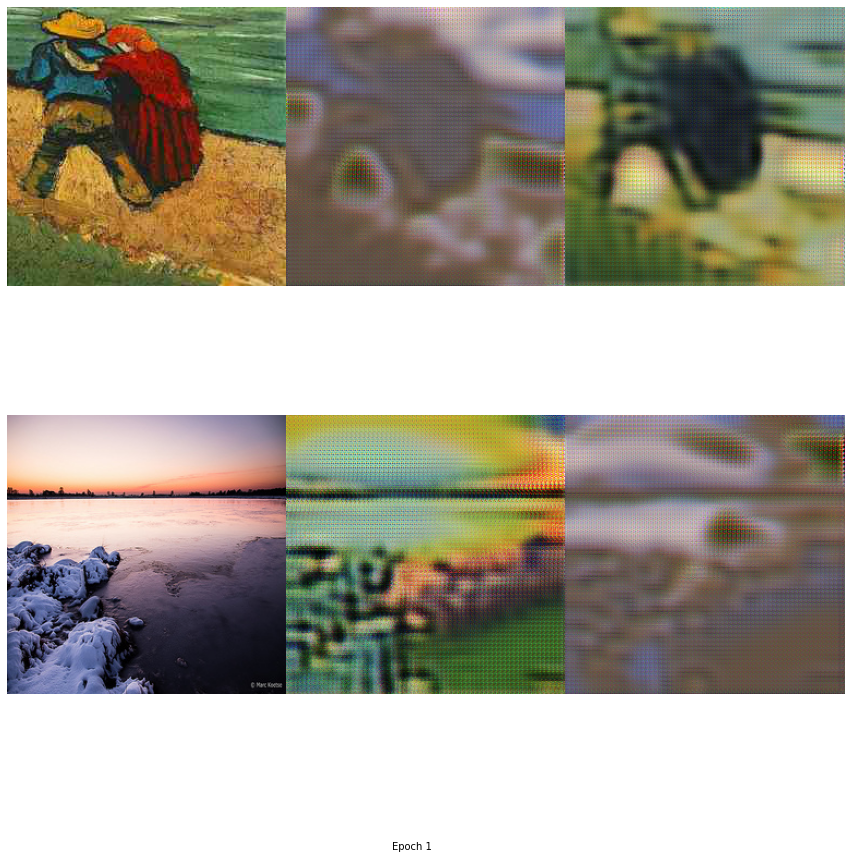

Epoch [2/5], Step [1/400], D_A_loss: 0.2479, D_B_loss: 0.2659, G_A_loss: 0.4495, G_B_loss: 0.8259
Epoch [2/5], Step [201/400], D_A_loss: 0.1159, D_B_loss: 0.0307, G_A_loss: 0.4697, G_B_loss: 0.6120



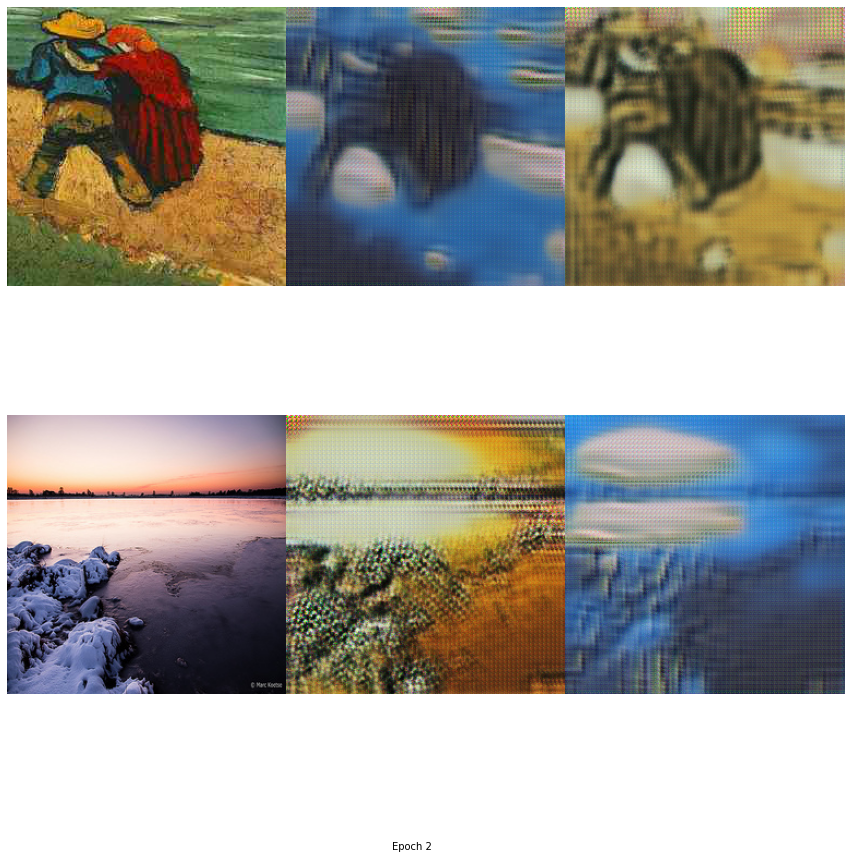

Epoch [3/5], Step [1/400], D_A_loss: 0.1339, D_B_loss: 0.2154, G_A_loss: 1.6098, G_B_loss: 0.2938
Epoch [3/5], Step [201/400], D_A_loss: 0.2330, D_B_loss: 0.0557, G_A_loss: 0.1072, G_B_loss: 0.1527



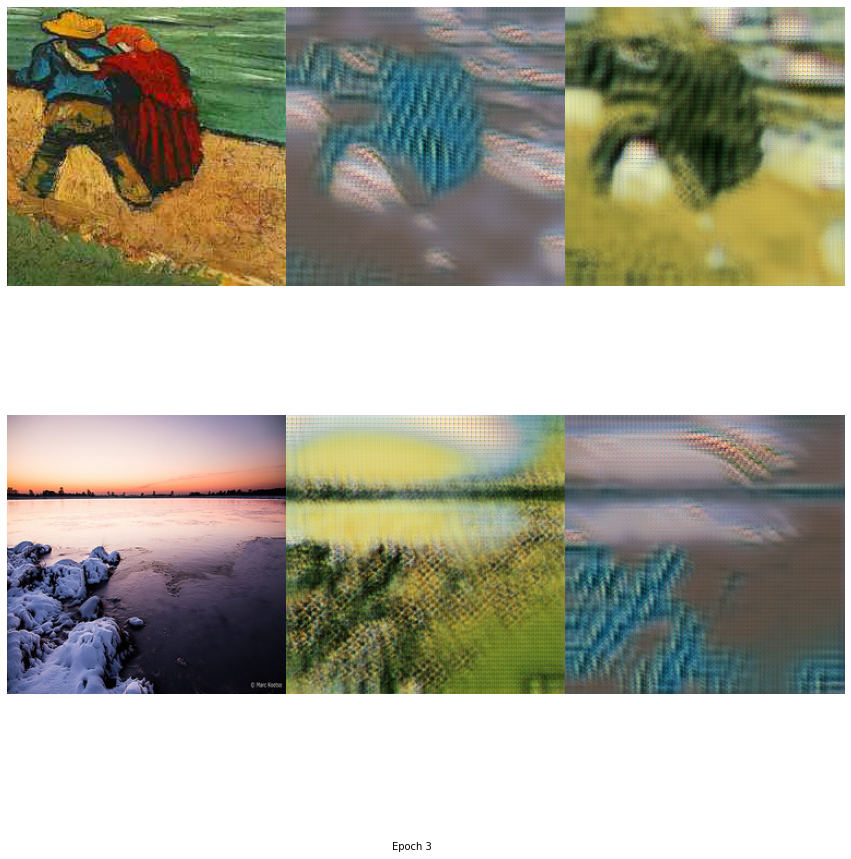

Epoch [4/5], Step [1/400], D_A_loss: 0.1939, D_B_loss: 0.1344, G_A_loss: 1.1063, G_B_loss: 0.3142
Epoch [4/5], Step [201/400], D_A_loss: 0.3030, D_B_loss: 0.1057, G_A_loss: 0.6246, G_B_loss: 0.1748



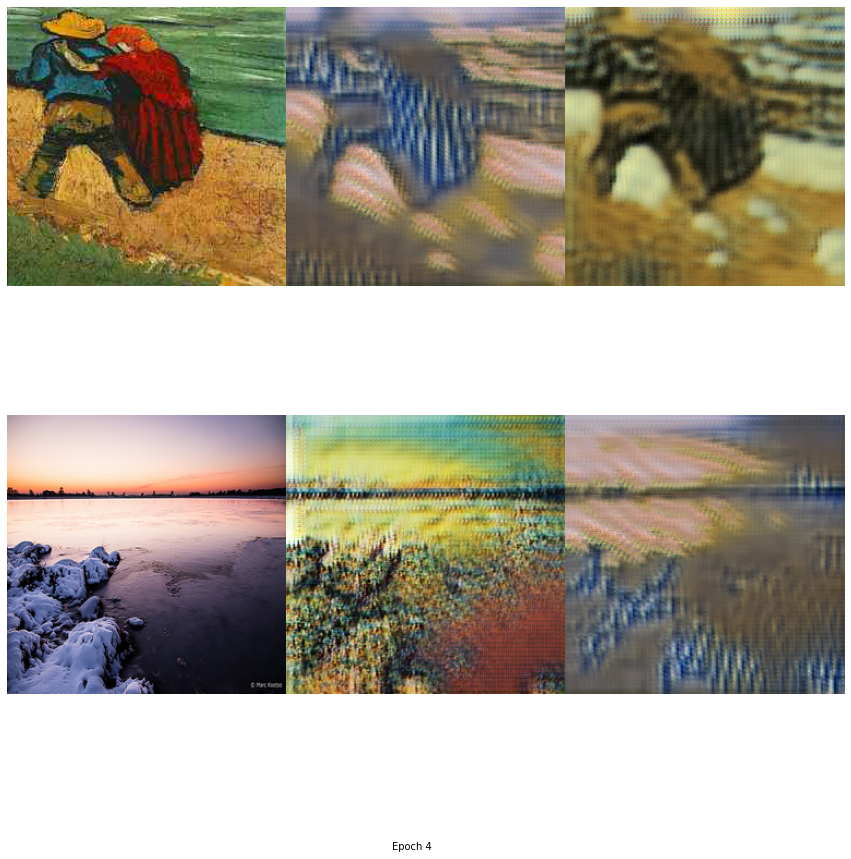

Epoch [5/5], Step [1/400], D_A_loss: 0.0610, D_B_loss: 0.1772, G_A_loss: 0.3652, G_B_loss: 0.1624
Epoch [5/5], Step [201/400], D_A_loss: 0.1476, D_B_loss: 0.0532, G_A_loss: 0.9237, G_B_loss: 0.6990



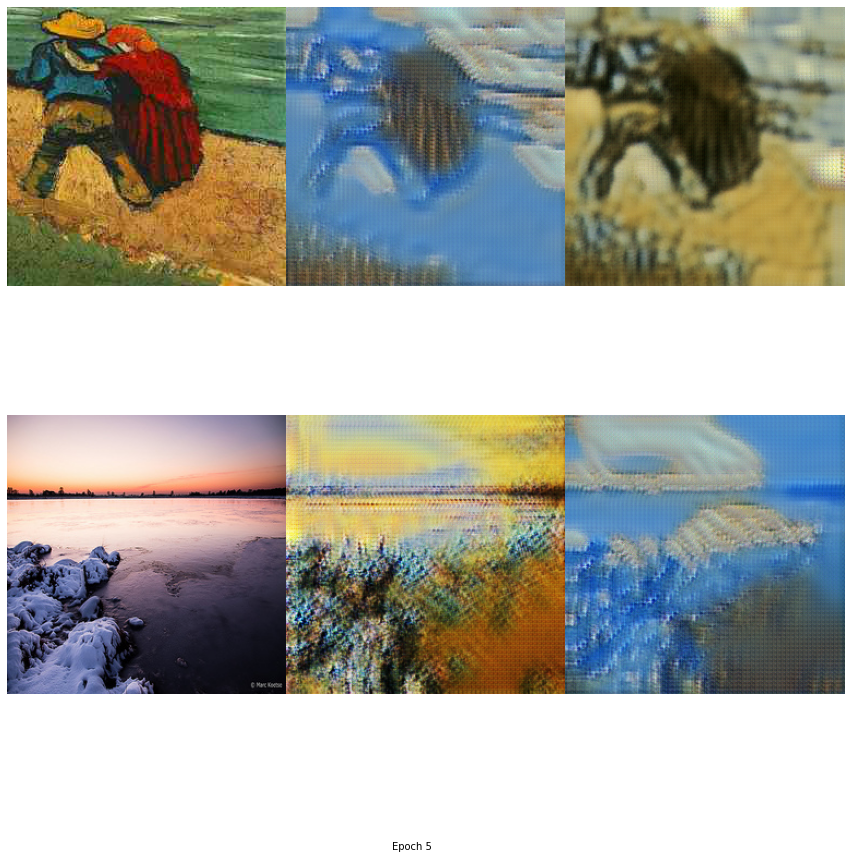

In [125]:
step = 0
for epoch in range(params['num_epochs']):
    D_A_losses = []
    D_B_losses = []
    G_A_losses = []
    G_B_losses = []
    cycle_A_losses = []
    cycle_B_losses = []
    
#     Learning rate decay
    if(epoch+1)>params['decay_epoch']:
        D_A_optimizer.param_groups[0]['lr'] -= params['lrD'] / (params['num_epochs'] - params['decay_epoch'])
        D_B_optimizer.param_groups[0]['lr'] -= params['lrD'] / (params['num_epochs'] - params['decay_epoch'])
        G_optimizer.param_groups[0]['lr'] -= params['lrG'] / (params['num_epochs'] - params['decay_epoch'])
        
    for i ,(real_A, real_B) in tqdm(enumerate(zip(train_data_loader_A,train_data_loader_B)),total=len(train_data_loader_A)):
        
        real_A = real_A.to(device)
        real_B = real_B.to(device)
        
#         Generator

        fake_B = G_A(real_A)
        D_B_fake_decision = D_B(fake_B)
        G_A_loss = MSE_Loss(D_B_fake_decision, Variable(torch.ones(D_B_fake_decision.size()).to(device)))
        
        recon_A = G_B(fake_B)
        cycle_A_loss = L1_Loss(real_A,recon_A) * params['lambdaA']
        
        learned_A = L1_loss(G_A(fake_B),real_A)
        
        fake_A = G_B(real_B)
        D_A_fake_decision = D_A(fake_A)
        G_B_loss = MSE_Loss(D_A_fake_decision, Variable(torch.ones(D_A_fake_decision.size()).to(device)))
        
        recon_B = G_A(fake_B)
        cycle_B_loss = L1_Loss(real_B,recon_B) * params['lambdaB']
        
        learned_B = L1_loss(G_B(fake_A),real_B)
        
        G_loss = G_A_loss+G_B_loss+cycle_A_loss+cycle_B_loss+learned_A+learned_B
        G_optimizer.zero_grad()
        G_loss.backward(retain_graph=True)
        G_optimizer.step()
        
#         Discriminator A
        D_A_real_decision = D_A(real_A)
        D_A_real_loss = MSE_loss(D_A_real_decision,Variable(torch.ones(D_A_real_decision.size()).to(device)))
        
        fake_A = fake_A_pool.query(fake_A)
        
        D_A_fake_decision = D_A(fake_A.detach())
        D_A_fake_loss = MSE_loss(D_A_fake_decision,Variable(torch.zeros(D_A_fake_decision.size()).to(device)))
        
        D_A_loss = (D_A_real_loss+D_A_fake_loss) * 0.5
        D_A_optimizer.zero_grad()
        D_A_loss.backward()
        D_A_optimizer.step()
        
#         Discriminator B
        D_B_real_decision = D_B(real_B)
        D_B_real_loss = MSE_loss(D_B_real_decision,Variable(torch.ones(D_B_real_decision.size()).to(device)))
        
        fake_B = fake_A_pool.query(fake_B)
        
        D_B_fake_decision = D_B(fake_B.detach())
        D_B_fake_loss = MSE_loss(D_B_fake_decision,Variable(torch.zeros(D_B_fake_decision.size()).to(device)))
        
        D_B_loss = (D_B_real_loss+D_B_fake_loss) * 0.5
        D_B_optimizer.zero_grad()
        D_B_loss.backward()
        D_B_optimizer.step()
        
        D_A_losses.append(D_A_loss.item())
        D_B_losses.append(D_B_loss.item())
        G_A_losses.append(G_A_loss.item())
        G_B_losses.append(G_B_loss.item())
        cycle_A_losses.append(cycle_A_loss.item())
        cycle_B_losses.append(cycle_B_loss.item())
        
        step +=1
        if i%200 == 0:
            print('Epoch [%d/%d], Step [%d/%d], D_A_loss: %.4f, D_B_loss: %.4f, G_A_loss: %.4f, G_B_loss: %.4f'
                  % (epoch+1, params['num_epochs'], i+1, len(train_data_loader_A), D_A_loss.item(), D_B_loss.item(), G_A_loss.item(), G_B_loss.item()))
    D_A_avg_loss = torch.mean(torch.FloatTensor(D_A_losses))
    D_B_avg_loss = torch.mean(torch.FloatTensor(D_B_losses))
    G_A_avg_loss = torch.mean(torch.FloatTensor(G_A_losses))
    G_B_avg_loss = torch.mean(torch.FloatTensor(G_B_losses))
    cycle_A_avg_loss = torch.mean(torch.FloatTensor(cycle_A_losses))
    cycle_B_avg_loss = torch.mean(torch.FloatTensor(cycle_B_losses))

    # avg loss values for plot
    D_A_avg_losses.append(D_A_avg_loss.item())
    D_B_avg_losses.append(D_B_avg_loss.item())
    G_A_avg_losses.append(G_A_avg_loss.item())
    G_B_avg_losses.append(G_B_avg_loss.item())
    cycle_A_avg_losses.append(cycle_A_avg_loss.item())
    cycle_B_avg_losses.append(cycle_B_avg_loss.item())
    
    # Show result for test image
    test_real_A = test_real_A_data.cuda()
    test_fake_B = G_A(test_real_A)
    test_recon_A = G_B(test_fake_B)

    test_real_B = test_real_B_data.cuda()
    test_fake_A = G_B(test_real_B)
    test_recon_B = G_A(test_fake_A)

    plot_train_result([test_real_A, test_real_B], [test_fake_B, test_fake_A], [test_recon_A, test_recon_B],
                            epoch, save=True)

In [ ]:
if not os.path.exists('output/output_images'):
    os.mkdir('output/output_images')
for i in range(100):
    random_A = random.randint(0,test_data_A.__len__())
    random_B = random.randint(0,test_data_B.__len__())
    test_real_A_data = test_data_A.__getitem__(random_A).unsqueeze(0) # Convert to 4d tensor (BxNxHxW)
    test_real_B_data = test_data_B.__getitem__(random_B).unsqueeze(0)
    test_real_A = test_real_A_data.to(device)
    test_fake_B = G_A(test_real_A)
    test_recon_A = G_B(test_fake_B)

    test_real_B = test_real_B_data.to(device)
    test_fake_A = G_B(test_real_B)
    test_recon_B = G_A(test_fake_A)

    plot_train_result([test_real_A, test_real_B], [test_fake_B, test_fake_A], [test_recon_A, test_recon_B],
                            epoch, save=True,output='../output_images')
